# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [25]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [26]:
''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [27]:
# tech stocks
coin = ['BTC', 'ETH']

In [28]:
# today
end = datetime.now()

In [29]:
start = datetime(2012, 1, 1)
start

datetime.datetime(2012, 1, 1, 0, 0)

In [36]:
from google.colab import drive
drive.mount('/content/drive/')

data_path = '/content/drive/My Drive/Colab Notebooks/data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [72]:
coin_selection = "BTC"
coin_data = {"BTC":"BTCUSD_4hours.csv"}

data = pd.read_csv(data_path + coin_data[coin_selection])

data = data.drop(columns="Unnamed: 0").set_index("date")
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [73]:
## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
    return data

add_ema(data)

def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi



rsi = computeRSI(data)

def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  

stoch_rsi(rsi)

def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

add_stoch_rsi(data)

def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

prices = data["log_close"]

get_bollinger_bands(prices, rate=20)

def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

add_bollinger(data,prices)

def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

add_vol_roc(data)
data.head(3)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,,
2011-12-31 08:00:00,4.39,4.390000,4.39,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,1.479329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 16:00:00,4.49,4.513333,4.49,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847,1.494235,1.493617,1.493776,1.493363,1.493493,1.493338,NaN,NaN,NaN,NaN,NaN,NaN,68.40758
2012-01-01 04:00:00,4.58,4.580000,4.58,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699,1.504954,1.503707,1.504029,1.503189,1.503453,1.503138,NaN,NaN,NaN,NaN,NaN,NaN,-0.95250


### Daily return

$ return = \frac{new - old}{old} $

In [74]:
data['4h Return'] = data['close'].pct_change()
data['4h Gradient'] = data['close'].diff()

In [75]:
data = data.dropna()

## Time-Series Visualisation

### Historical Stock Prices

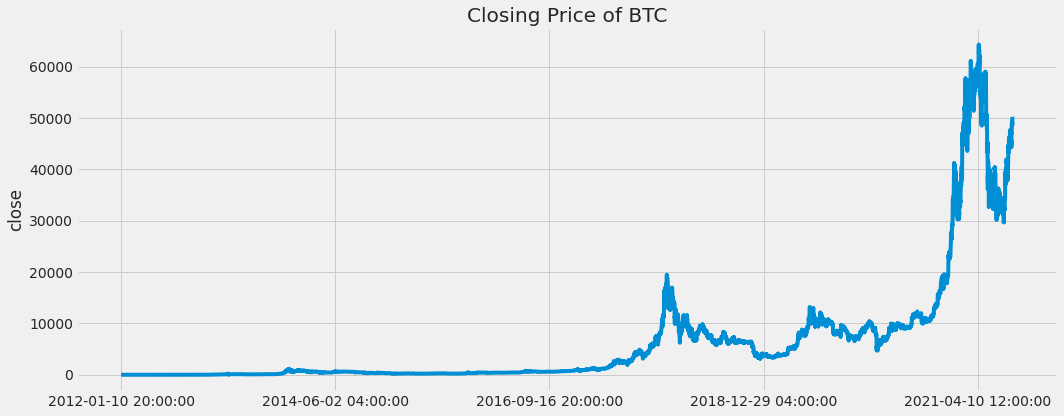

In [76]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['close'].plot()
plt.ylabel('close')
plt.xlabel(None)
plt.title(f"Closing Price of {coin_selection}")
    
plt.tight_layout()

### Volumes traded

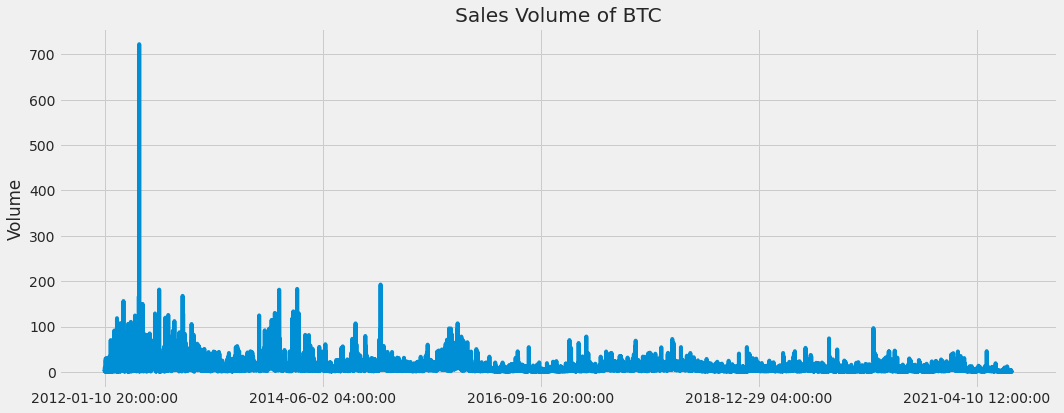

In [77]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of BTC")
    
plt.tight_layout()

In [79]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc,4h Return,4h Gradient
date,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-10 20:00:00,7.140000,7.140000,7.140000,7.140000,4.598039,1.965713,1.965713,1.965713,1.965713,1.889085,1.852109,1.865931,1.821679,1.838512,1.818119,68.562494,24.403826,13.769771,1.880396,1.986887,1.773904,0.656744,0.052580,0.356667
2012-01-11 08:00:00,7.033333,7.033333,7.033333,7.033333,1.858932,1.949820,1.949820,1.949820,1.949820,1.898467,1.859967,1.874226,1.828535,1.845937,1.824849,65.970885,37.306777,24.696599,1.890427,1.981574,1.799280,-0.595712,-0.014939,-0.106667
2012-01-11 12:00:00,7.201538,7.205769,7.201538,7.205769,1.895918,1.974294,1.974876,1.974294,1.974876,1.910262,1.869149,1.884142,1.836255,1.854458,1.832400,68.023084,51.197785,37.636130,1.898878,1.988336,1.809419,0.019896,0.024517,0.172436
2012-01-11 16:00:00,6.950000,6.950000,6.950000,6.950000,2.987143,1.938716,1.938716,1.938716,1.938716,1.914652,1.874676,1.889500,1.841588,1.859976,1.837674,62.193690,50.078456,46.194339,1.902687,1.992116,1.813258,0.575566,-0.035495,-0.255769
2012-01-11 20:00:00,7.000000,7.000000,7.000000,7.000000,8.315000,1.945910,1.945910,1.945910,1.945910,1.919473,1.880305,1.895023,1.846949,1.865558,1.842969,62.875361,44.821949,48.699397,1.906934,1.996089,1.817779,1.783596,0.007194,0.050000


Text(0.5, 1.0, '4h Return  for BTC')

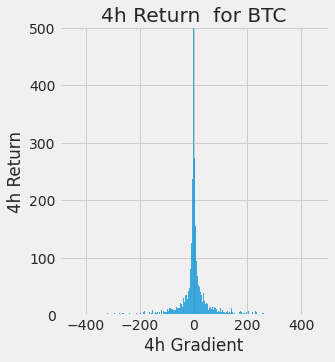

In [81]:
sns.displot(data = data, x= '4h Gradient')
plt.ylabel('4h Return')
plt.xlim([-500,500])
plt.ylim([0,500])
plt.title(f"4h Return  for {coin_selection}");

In [83]:
## get only the close data
selected_features=["close"]
selected_data = data[selected_features]
selected_data.sample(10)

,close
date,
2020-09-21 04:00:00,10955.522083
2018-03-20 00:00:00,8511.544000
2012-09-10 08:00:00,10.854762
2019-12-12 20:00:00,7207.852101
2012-03-11 12:00:00,4.840000
2021-04-03 12:00:00,59257.222500
2020-01-08 00:00:00,8297.510208
2016-10-20 08:00:00,628.139926
2019-08-23 00:00:00,10122.149831


## Apple Stock Price

### Temporal Train-Test Split

In [84]:
train_percentage = 95

In [91]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

19768

In [92]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]

## LSTM

In [93]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = pd.DataFrame(minmax_scaler.transform(data_train))
data_train_scaled.columns = data_train.columns
data_test_scaled = pd.DataFrame(minmax_scaler.transform(data_test))
data_test_scaled.columns = data_test.columns

In [94]:
minmax_scaler.data_max_

array([57814.29254167])

In [95]:
minmax_scaler.data_min_

array([4.2275])

In [96]:
data_train_scaled.sample(5)

,close
9036,0.007105
8439,0.007337
15872,0.131738
14028,0.128730
8193,0.005484


In [97]:
data_test_scaled.sample(5)

,close
610,0.618472
459,0.781603
112,0.979248
841,0.514591
881,0.654826


### Creating subsequences...

In [99]:
def subsequence(df, length, horizon):
    last_possible_start = len(df) - length - horizon
    random_start = np.random.randint(0, last_possible_start)
    X = df[random_start:random_start + length]
    y = df.iloc[random_start + length + horizon]['close']
    
    return X, y

In [104]:
length = 60
horizon  = 1

X_train, y_train = subsequence(data_train, length, horizon)
y_train

X_test, y_test = subsequence(data_test, length, horizon)
y_test

8093.83050209205

**`multiple_subsequences`**

In [162]:
def multiple_subsequences(df, number_of_subsequences, length ,horizon = 1):
    list_of_lengths = np.random.randint(66, 72, number_of_subsequences)
    if not length:
      list_of_X = [subsequence(df, list_of_lengths[_], horizon)[0] for _ in range(number_of_subsequences)]
      list_of_y = [subsequence(df, list_of_lengths[_], horizon)[1] for _ in range(number_of_subsequences)] # 
    else:
      list_of_X = [subsequence(df, length, horizon)[0] for _ in range(number_of_subsequences)]
      list_of_y = [subsequence(df, length, horizon)[1] for _ in range(number_of_subsequences)] #       
    
    return list_of_X, list_of_y

In [163]:
X_train, y_train = multiple_subsequences(data_train_scaled, 2000, length=None, horizon = 1)
X_test, y_test = multiple_subsequences(data_test_scaled, 1000, length=None,horizon = 1)

### LSTM

#### Padding...

(array([146.,   0., 165.,   0., 173.,   0., 179.,   0., 155., 182.]),
 array([66. , 66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5, 70. , 70.5, 71. ]),
 <a list of 10 Patch objects>)

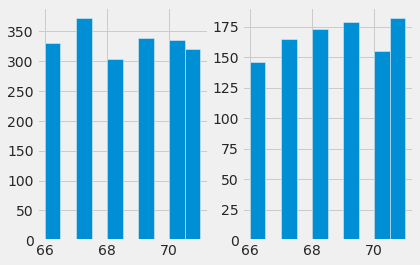

In [164]:
plt.subplot(1,2,1)
plt.hist([len(_) for _ in X_train])
plt.subplot(1,2,2)
plt.hist([len(_) for _ in X_test])

In [165]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train, value = -999, padding = "post", dtype="float64")
X_test_pad = pad_sequences(X_test, value = -999, padding = "post", dtype="float64")

In [166]:
X_train_pad.shape, X_test_pad.shape

((2000, 71, 1), (1000, 71, 1))

#### RNN Architecture

In [167]:
pd.DataFrame(y_test).shape

(1000, 1)

In [168]:
from tensorflow.keras import metrics

my_mae = metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)


In [169]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()
model.add(layers.Masking(mask_value=-999., input_shape=X_train_pad.shape[1:]))
model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh",
                     input_shape = X_train_pad[0].shape))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "tanh"))

model.add(layers.Dense(25,
                         activation="relu"))

model.add(layers.Dense(1,
                      activation="relu"))

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 71, 1)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 71, 128)           66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [170]:
model.compile(loss="mse",
             optimizer = "rmsprop",
             metrics = [my_mae])

#### Training

In [171]:
#### perhaps create a validation and train sets by hand

In [172]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, monitor = "val_mean_absolute_error")

history = model.fit(X_train_pad, np.array(y_train),
          validation_split = 0.3,
         batch_size=16,
         epochs=5,
         verbose = 1,
         callbacks = [es])

Epoch 1/5
88/88 [==============================] - 21s 157ms/step - loss: 0.0132 - mean_absolute_error: 0.0781 - val_loss: 0.0123 - val_mean_absolute_error: 0.0835
Epoch 2/5
88/88 [==============================] - 11s 130ms/step - loss: 0.0129 - mean_absolute_error: 0.0780 - val_loss: 0.0126 - val_mean_absolute_error: 0.0855
Epoch 3/5
88/88 [==============================] - 11s 130ms/step - loss: 0.0128 - mean_absolute_error: 0.0776 - val_loss: 0.0117 - val_mean_absolute_error: 0.0774
Epoch 4/5
88/88 [==============================] - 11s 129ms/step - loss: 0.0129 - mean_absolute_error: 0.0785 - val_loss: 0.0116 - val_mean_absolute_error: 0.0747
Epoch 5/5
88/88 [==============================] - 11s 130ms/step - loss: 0.0127 - mean_absolute_error: 0.0779 - val_loss: 0.0116 - val_mean_absolute_error: 0.0718


In [202]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

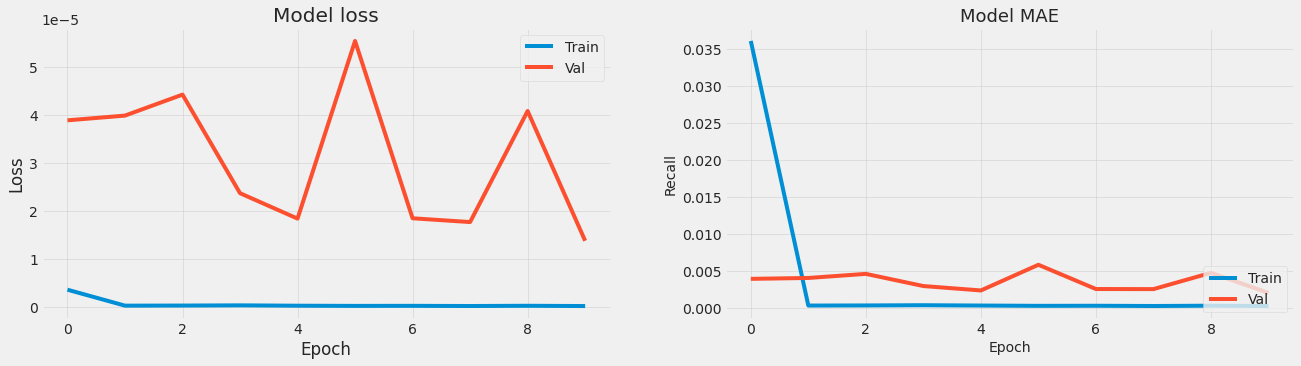

In [203]:
plot_loss_mae(history)

#### Evaluating

In [205]:
res = model.evaluate(X_test_pad, np.array(y_test), verbose = 1)
res


ValueError: ignored

#### Predictions

In [175]:
predictions = model.predict(X_test_pad)


In [176]:
len(predictions), len(y_test)

(1000, 1000)

In [177]:
predictions[0:3]

array([[0.05379521],
       [0.05472737],
       [0.05300941]], dtype=float32)

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [178]:
a = minmax_scaler.data_min_
b = minmax_scaler.data_max_

In [179]:
unscaled_predictions = predictions * (b - a) + a
unscaled_predictions[:3]
# len is 1000

array([[3114.13193247],
       [3168.02042228],
       [3068.7046932 ]])

In [180]:
unscaled_predictions = minmax_scaler.inverse_transform(predictions)
unscaled_predictions[:3]

array([[3114.1318],
       [3168.0205],
       [3068.7046]], dtype=float32)

In [181]:
unscaled_y_test = minmax_scaler.inverse_transform(np.array([y_test])).T
unscaled_y_test[:3]

array([[53183.98066667],
       [41506.68754167],
       [32037.91779167]])

In [182]:
unscaled_y_test  = np.array(y_test)*(b - a) + a
unscaled_y_test[:3]

array([53183.98066667, 41506.68754167, 32037.91779167])

In [183]:
unscaled_predictions.shape

(1000, 1)

In [184]:
unscaled_y_test.shape

(1000,)

In [185]:
#MAE
np.mean(np.abs(unscaled_y_test - unscaled_predictions))

41600.62058052335

In [186]:
#MSE
np.sqrt(np.mean((unscaled_y_test - unscaled_predictions)**2))

42874.53050856524

In [187]:
predictions_train = model.predict(X_train_pad)
unscaled_predictions_train = minmax_scaler.inverse_transform(predictions_train)
unscaled_y_train = minmax_scaler.inverse_transform(np.array([y_train])).T
np.mean(np.abs(unscaled_y_train - unscaled_predictions_train))

4261.574444805618

## Second round

In [248]:
dataset = data[["close"]].values
dataset

array([[7.14000000e+00],
       [7.03333333e+00],
       [7.20576923e+00],
       ...,
       [4.88101687e+04],
       [4.97830037e+04],
       [5.02774752e+04]])

In [250]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[4.52713449e-05],
       [4.36133386e-05],
       [4.62936493e-05],
       ...,
       [7.58630249e-01],
       [7.73751811e-01],
       [7.81437780e-01]])

In [251]:
length = 60
horizon  = 1

training_split = 0.85
training_data_length = int(np.ceil(len(dataset) * training_split))
training_data_length

17688

In [252]:
# Create the training data set 
# Create the scaled training data set

train_data = scaled_data[0:int(training_data_length), :]
# Split the data into x_train and y_train data sets
y_train = []

x_train = [train_data[i-length:i, 0] for i in range(length, len(train_data))]
y_train = [train_data[i, 0] for i in range(length, len(train_data))]
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [253]:
# Create the testing data set
# Create a new array containing scaled values from index 543 to 2002 
test_data = scaled_data[training_data_length - length: , :]
# Create the data sets x_test and y_test

y_test = dataset[training_data_length:, :]
x_test = [test_data[i-length:i, 0] for i in range(length, len(test_data))]
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [254]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17628, 60, 1) (17628,)
(3121, 60, 1) (3121, 1)


In [255]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = my_mae)

# Train the model
history = model.fit(x_train, y_train, batch_size=8, epochs=5, validation_split = 0.4)

Epoch 1/5
1322/1322 [==============================] - 88s 65ms/step - loss: 2.2268e-06 - mean_absolute_error: 6010.3242 - val_loss: 2.4014e-05 - val_mean_absolute_error: 0.0028
Epoch 2/5
1322/1322 [==============================] - 85s 64ms/step - loss: 2.9615e-07 - mean_absolute_error: 4.2055e-04 - val_loss: 1.9942e-05 - val_mean_absolute_error: 0.0025
Epoch 3/5
1322/1322 [==============================] - 85s 64ms/step - loss: 2.5390e-07 - mean_absolute_error: 3.8235e-04 - val_loss: 6.1235e-05 - val_mean_absolute_error: 0.0059
Epoch 4/5
1322/1322 [==============================] - 85s 64ms/step - loss: 2.4638e-07 - mean_absolute_error: 3.7158e-04 - val_loss: 1.6666e-05 - val_mean_absolute_error: 0.0024
Epoch 5/5
1322/1322 [==============================] - 84s 64ms/step - loss: 2.0177e-07 - mean_absolute_error: 3.3586e-04 - val_loss: 1.3566e-05 - val_mean_absolute_error: 0.0020


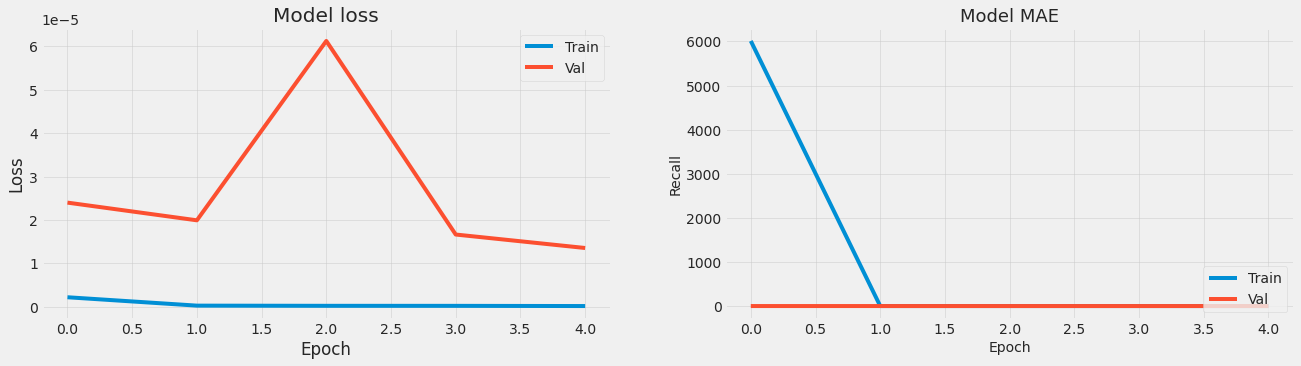

In [256]:
plot_loss_mae(history)

In [258]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[:3]

array([[6369.935 ],
       [6344.9556],
       [6299.4785]], dtype=float32)

In [260]:
y_test.shape, predictions.shape

((3121, 1), (3121, 1))

In [259]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2198.9830107136213

In [261]:
model.evaluate(x_test, y_test)

98/98 [==============================] - 4s 29ms/step - loss: 1009268352.0000 - mean_absolute_error: 26377.2500


[1009268352.0, 26377.25]

In [262]:
# Plot the data
train = selected_data[:training_data_length]
valid = selected_data[training_data_length:].copy()

In [263]:
train

,close
date,
2012-01-10 20:00:00,7.140000
2012-01-11 08:00:00,7.033333
2012-01-11 12:00:00,7.205769
2012-01-11 16:00:00,6.950000
2012-01-11 20:00:00,7.000000
...,...
2020-03-20 08:00:00,6573.345583
2020-03-20 12:00:00,6636.824375
2020-03-20 16:00:00,6450.654477


In [264]:
valid

,close
date,
2020-03-21 04:00:00,6184.227940
2020-03-21 08:00:00,6071.952469
2020-03-21 12:00:00,6128.829828
2020-03-21 16:00:00,6167.223013
2020-03-21 20:00:00,6252.137064
...,...
2021-08-22 12:00:00,48769.737750
2021-08-22 16:00:00,48591.580833
2021-08-22 20:00:00,48810.168750


In [265]:
valid["Predictions"] = predictions
valid

,close,Predictions
date,,
2020-03-21 04:00:00,6184.227940,6369.935059
2020-03-21 08:00:00,6071.952469,6344.955566
2020-03-21 12:00:00,6128.829828,6299.478516
2020-03-21 16:00:00,6167.223013,6257.541016
2020-03-21 20:00:00,6252.137064,6227.391113
...,...,...
2021-08-22 12:00:00,48769.737750,46196.675781
2021-08-22 16:00:00,48591.580833,46179.105469
2021-08-22 20:00:00,48810.168750,46122.453125


In [266]:
valid.index = pd.to_datetime(valid.index, format = "%Y-%m-%d %H:%M:%S")
train.index = pd.to_datetime(train.index, format = "%Y-%m-%d %H:%M:%S")

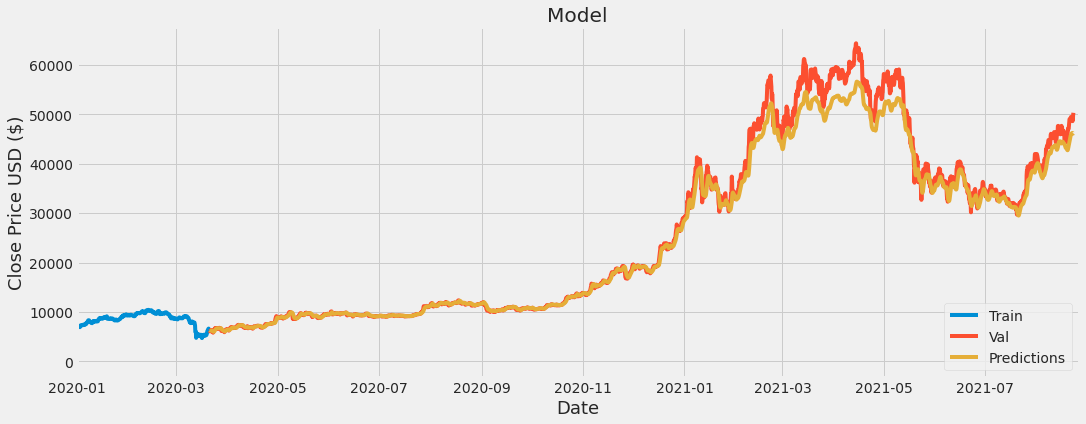

In [269]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.xlim([datetime.date(2020, 1, 1), datetime.datetime.now()])
plt.show()